<div style="text-align: center;">

# Model Compression using Low-Rank Approximation (SVD)

</div>

**Notebook:** `CDM__6_Final.ipynb`

**Project Goal:** Implement and evaluate model compression techniques using Singular Value Decomposition (SVD) on a ResNet-18 architecture trained on CIFAR-10.

**Abstract:** This notebook follows a step-by-step approach to compress deep learning models by replacing dense linear layers with low-rank approximations. The workflow includes:
1.  **Spectral Analysis:** Analyzing the singular value spectrum of model weights to determine redundancy.
2.  **Compression Implementation:** Replacing layers with truncated SVD decompositions at varying compression rates (0%, 50%, 80%).
3.  **Performance Evaluation:** Measuring the impact on parameter count, initial accuracy, recovered accuracy after fine-tuning, and CPU inference latency.

In [1]:
# -----------------------------------------------------------
# Core Libraries
# -----------------------------------------------------------
import numpy as np                 # Numerical operations
import pandas as pd                # Data manipulation
import matplotlib.pyplot as plt    # Visualization
import time                        # Timing operations
import copy                        # Model copying

# -----------------------------------------------------------
# PyTorch & Deep Learning
# -----------------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

# -----------------------------------------------------------
# Plotting Configuration
# -----------------------------------------------------------
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

# -----------------------------------------------------------
# Device Configuration
# -----------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -----------------------------------------------------------   
# Suppress Warnings
# -----------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

Using device: cuda


In [2]:
# -----------------------------------------------------------
# 1.1 Data Loading & Preprocessing (CIFAR-10)
# -----------------------------------------------------------
BATCH_SIZE = 128

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

print("Loading CIFAR-10 dataset...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# -----------------------------------------------------------
# 1.1 Model Initialization (ResNet-18)
# -----------------------------------------------------------
def get_base_model():
    # Load pre-trained ResNet18
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    # Modify the final fully connected layer for 10 classes (CIFAR-10)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

base_model = get_base_model().to(device)

# -----------------------------------------------------------
# Helper Functions: Train & Evaluate
# -----------------------------------------------------------
def train_model(model, epochs=1, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return 100 * correct / total

print("Training baseline model (1 Epoch) to adapt to CIFAR-10...")
train_model(base_model, epochs=1)
baseline_acc = evaluate_model(base_model)
print(f"Baseline Accuracy: {baseline_acc:.2f}%")

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Training baseline model (1 Epoch) to adapt to CIFAR-10...
Baseline Accuracy: 74.13%


Middle Layer Shape (Reshaped for SVD): (128, 576)
Final Layer Shape: (10, 512)


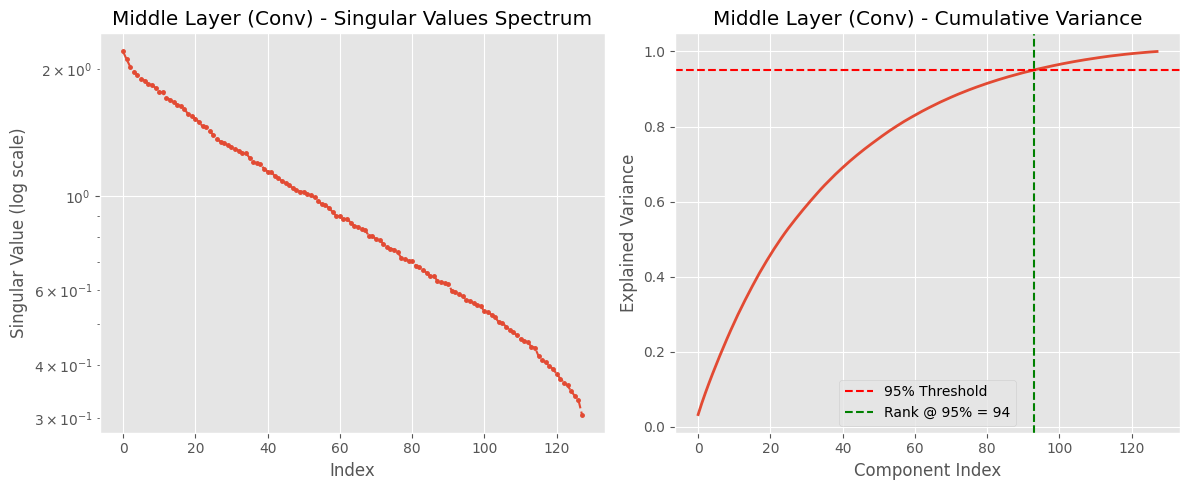

>>> Middle Layer (Conv): Rank required for 95% variance: 94 / 128


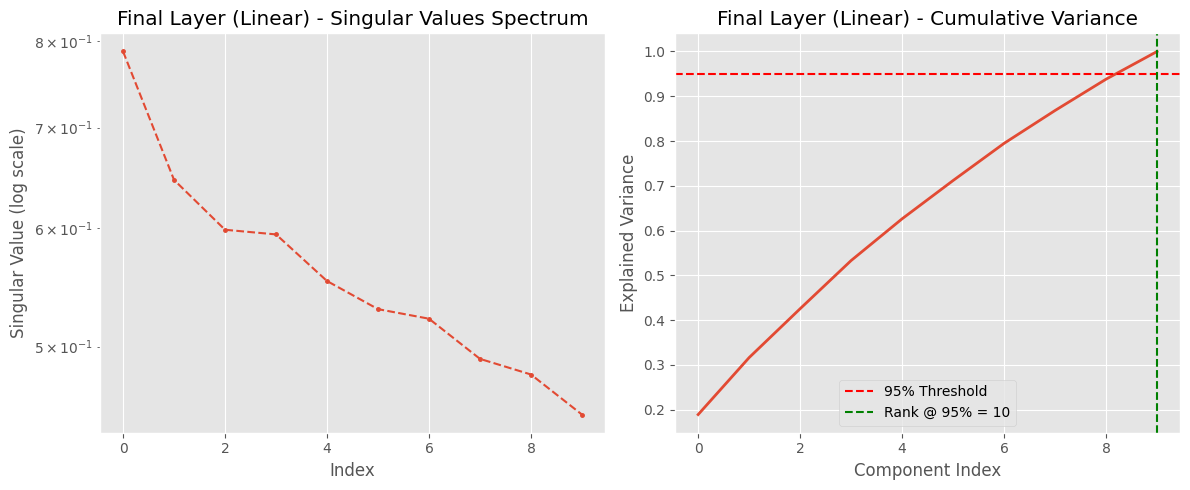

>>> Final Layer (Linear): Rank required for 95% variance: 10 / 10


In [3]:
# -----------------------------------------------------------
# Part 1: Spectral Analysis of Model Weights
# -----------------------------------------------------------

# 1.2 Extract Weights (Middle Layer & Final Layer)
# Middle Layer: layer2.0.conv1 (Convolutional)
# Final Layer: fc (Linear)
mid_layer_weights = base_model.layer2[0].conv1.weight.data.cpu()
# Reshape Conv2d (Out, In, k, k) -> Matrix (Out, In*k*k) for SVD
mid_layer_mat = mid_layer_weights.view(mid_layer_weights.shape[0], -1).numpy()

final_layer_weights = base_model.fc.weight.data.cpu().numpy()

print(f"Middle Layer Shape (Reshaped for SVD): {mid_layer_mat.shape}")
print(f"Final Layer Shape: {final_layer_weights.shape}")

# 1.3 Plot Singular Values & Analyze Variance
def analyze_svd(matrix, layer_name):
    # Compute SVD
    _, S, _ = np.linalg.svd(matrix, full_matrices=False)
    
    # Calculate Energy (Squared Singular Values)
    energy = S ** 2
    cumulative_energy = np.cumsum(energy) / np.sum(energy)
    
    # Find Rank for 95% Variance
    k_idx = np.searchsorted(cumulative_energy, 0.95)
    rank_95 = k_idx + 1
    
    # Visualization
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Singular Values Spectrum
    ax[0].semilogy(S, marker='.', linestyle='--', markersize=5)
    ax[0].set_title(f'{layer_name} - Singular Values Spectrum')
    ax[0].set_xlabel('Index')
    ax[0].set_ylabel('Singular Value (log scale)')
    
    # Cumulative Energy
    ax[1].plot(cumulative_energy, linewidth=2)
    ax[1].axhline(0.95, color='r', linestyle='--', label='95% Threshold')
    ax[1].axvline(k_idx, color='g', linestyle='--', label=f'Rank @ 95% = {rank_95}')
    ax[1].set_title(f'{layer_name} - Cumulative Variance')
    ax[1].set_xlabel('Component Index')
    ax[1].set_ylabel('Explained Variance')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f">>> {layer_name}: Rank required for 95% variance: {rank_95} / {len(S)}")
    return rank_95

rank_mid = analyze_svd(mid_layer_mat, "Middle Layer (Conv)")
rank_final = analyze_svd(final_layer_weights, "Final Layer (Linear)")

In [4]:
# -----------------------------------------------------------
# Part 2: Practical Compression Implementation
# -----------------------------------------------------------

# 2.1 Function to Replace Linear Layer with Low-Rank Layers
def decompose_linear_layer(layer, compression_rate):
    """
    Decomposes a Linear layer W (m x n) into two layers W1 (m x k) and W2 (k x n)
    using Truncated SVD to achieve the target parameter reduction.
    """
    W = layer.weight.data
    bias = layer.bias.data if layer.bias is not None else None
    out_features, in_features = W.shape
    
    original_params = out_features * in_features
    target_params = (1 - compression_rate) * original_params
    
    # Calculate Rank k: k * (in + out) = target_params
    k = int(target_params / (in_features + out_features))
    k = max(1, min(k, min(out_features, in_features)))
    
    # SVD Decomposition
    U, S, Vt = torch.linalg.svd(W, full_matrices=False)
    
    # Truncate to Rank k
    U_k = U[:, :k]
    S_k = S[:k]
    Vt_k = Vt[:k, :]
    
    # Balance scaling by sqrt(S)
    sqrt_S = torch.diag(torch.sqrt(S_k))
    W_layer1 = torch.matmul(sqrt_S, Vt_k)  # (k, in)
    W_layer2 = torch.matmul(U_k, sqrt_S)   # (out, k)
    
    # Create new sequential layers
    layer1 = nn.Linear(in_features, k, bias=False)
    layer2 = nn.Linear(k, out_features, bias=True)
    
    layer1.weight.data = W_layer1
    layer2.weight.data = W_layer2
    if bias is not None:
        layer2.bias.data = bias
        
    return nn.Sequential(layer1, layer2)

# 2.2 Apply Compression to Model
def apply_compression(model, rate):
    model_copy = copy.deepcopy(model)
    # Apply to the final fully connected layer
    if rate > 0:
        model_copy.fc = decompose_linear_layer(model_copy.fc, rate)
    return model_copy.to(device)

In [5]:
# -----------------------------------------------------------
# Part 2 & 3: Evaluation Loop (Accuracy, Fine-tuning, Speed)
# -----------------------------------------------------------

# 3.2 Speed Measurement Function (CPU)
def measure_inference_speed_cpu(model, sample_input, iterations=50):
    model.to('cpu')
    model.eval()
    sample_input = sample_input.to('cpu')
    
    # Warmup
    with torch.no_grad():
        model(sample_input)
    
    start_time = time.time()
    with torch.no_grad():
        for _ in range(iterations):
            _ = model(sample_input)
    end_time = time.time()
    
    avg_ms = ((end_time - start_time) / iterations) * 1000
    return avg_ms

compression_rates = [0.0, 0.50, 0.80]
results_data = []

print("Starting Evaluation Loop...")
print("-"*60)

for rate in compression_rates:
    print(f"Processing Compression Rate: {rate*100}%")
    
    # 1. Compress
    model = apply_compression(base_model, rate)
    
    # 2. Count Parameters
    params = sum(p.numel() for p in model.parameters())
    
    # 3. Initial Accuracy (2.2)
    init_acc = evaluate_model(model)
    print(f"  > Initial Accuracy: {init_acc:.2f}%")
    
    # 4. Fine-tuning (3.1 - At least 3 epochs)
    if rate > 0:
        print(f"  > Fine-tuning for 3 epochs...")
        train_model(model, epochs=3, lr=0.0005)
    
    # 5. Final Accuracy
    final_acc = evaluate_model(model)
    print(f"  > Final Accuracy: {final_acc:.2f}%")
    
    # 6. Inference Speed on CPU (3.2)
    dummy_input = torch.randn(BATCH_SIZE, 3, 32, 32)
    latency_ms = measure_inference_speed_cpu(model, dummy_input)
    print(f"  > CPU Latency: {latency_ms:.2f} ms/batch")
    
    results_data.append({
        'Rate': rate * 100,
        'Parameters': params,
        'Initial Accuracy': init_acc,
        'Final Accuracy': final_acc,
        'Latency (ms)': latency_ms
    })
    print("-"*60)

Starting Evaluation Loop...
------------------------------------------------------------
Processing Compression Rate: 0.0%
  > Initial Accuracy: 74.13%
  > Final Accuracy: 74.13%
  > CPU Latency: 106.31 ms/batch
------------------------------------------------------------
Processing Compression Rate: 50.0%
  > Initial Accuracy: 60.75%
  > Fine-tuning for 3 epochs...
  > Final Accuracy: 80.60%
  > CPU Latency: 101.68 ms/batch
------------------------------------------------------------
Processing Compression Rate: 80.0%
  > Initial Accuracy: 19.68%
  > Fine-tuning for 3 epochs...
  > Final Accuracy: 41.25%
  > CPU Latency: 115.39 ms/batch
------------------------------------------------------------



Final Results Table:
 Rate  Parameters  Initial Accuracy  Final Accuracy  Latency (ms)
  0.0    11181642             74.13           74.13    106.313834
 50.0    11178610             60.75           80.60    101.678429
 80.0    11177044             19.68           41.25    115.392408


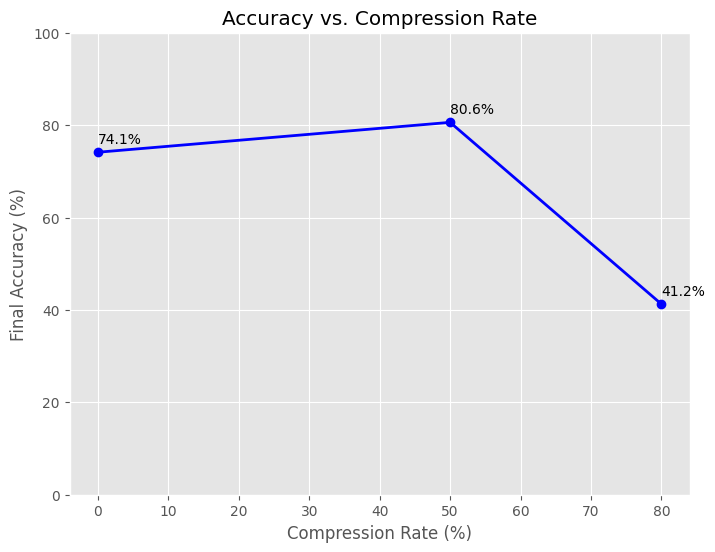

In [6]:
# -----------------------------------------------------------
# Results: Comparison Tables & Plots
# -----------------------------------------------------------

# 2.3 Parameter Comparison Table
df_results = pd.DataFrame(results_data)
print("\nFinal Results Table:")
print(df_results.to_string(index=False))

# 3.3 Plot Accuracy vs Compression Rate
plt.figure(figsize=(8, 6))
plt.plot(df_results['Rate'], df_results['Final Accuracy'], marker='o', linestyle='-', linewidth=2, color='b')
plt.title('Accuracy vs. Compression Rate')
plt.xlabel('Compression Rate (%)')
plt.ylabel('Final Accuracy (%)')
plt.grid(True)
plt.ylim(0, 100)

# Annotate points
for i, row in df_results.iterrows():
    plt.annotate(f"{row['Final Accuracy']:.1f}%", 
                 (row['Rate'], row['Final Accuracy'] + 2))

plt.show()